In [1]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [154]:
def Properties(SpecHeat,dTad,B_exp,B_l_int,B_h_int,T,N_ml): #Get the properties on the low and high field

    C_l = zeros([N_ml,len(T)])
    C_h = zeros([N_ml,len(T)])
    dT_l = zeros([N_ml,len(T)])
    dT_h = zeros([N_ml,len(T)])
    
    A_2 = 0
    A_1 = 0
    
    for i in range(K):
        if B_exp[i] == B_l_int and B_exp[i-1]< B_l_int:
            A_2 = np.int(i)  
        if B_exp[i] == B_l_int:
            for j in range(N_ml):
                C_l[j][i-A_2]=C[j,i]
                dT_l[j][i-A_2]=dT[j,i]

        if B_exp[i] == B_h_int and B_exp[i-1]< B_h_int:
            A_1 = np.int(i)
        if B_exp[i] == B_h_int:
            for j in range(N_ml):
                C_h[j][i-A_1]=C[j,i]
                dT_h[j][i-A_1]=dT[j,i]
                
    return(C_l,C_h,dT_l,dT_h)

In [155]:
C

array([[256.63089258, 256.70987654, 256.78886049, ..., 240.30764771,
        240.08272037, 239.85779302],
       [260.15348618, 260.23676263, 260.32003909, ..., 221.34092515,
        221.1437586 , 220.94659206],
       [275.37977934, 275.49387629, 275.60797324, ..., 221.13559451,
        220.95812051, 220.78064651],
       [284.59260569, 284.71754317, 284.84248065, ..., 219.11085114,
        218.96257581, 218.81430047]])

In [156]:
C_l, C_h, dT_l, dT_h =  Properties(SpecHeat,dTad,B_exp,B_l_int,B_h_int,T,N_ml)

In [ ]:
SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)

In [133]:
def SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d):


    C_mag = []
    C_dmag = []
    dT_mag = []
    dT_dmag = []

    T_int = np.arange(Tc,Th+0.01,0.1)

    N_l = len(T_layer)

    A = np.int((Tc - min(T_exp))/0.1)



    T_t = []
    L = 0

    for i in range(N_l):
        L = L + L_layer[i]
        T_tr = Tc + 0.001 +L/100*(Th-Tc)
        T_t.append(T_tr)

    k = 0    
    for i in range (len(T_int)):
        #print(T_int[i])
        if T_int[i] <=T_t[k]:
            #print(T_int[i],T_t[k])
            for j in range(len(T_l)):
                #print(T_layer[k],T_l[j],T_layer[k],T_l[j])
                if T_layer[k] >= T_l[j] and T_layer[k] < T_l[j+1]:
                    #print('Hello')
                    #print(i,j,k)
                    #print(T_int[i],T_t[k],T_layer[k],T_l[j],T_l[j+1])
                    C_mag.append(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j+1][int(i+A)]-(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j+1][int(i+A)]-(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j+1][int(i+A)]-(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
        else:
            for j in range(len(T_l)):
                print(T_layer[k],T_l[j])
                if T_layer[k+1] >= T_l[j] and T_layer[k+1] < T_l[j+1]:
                    #print(i,j,k)
                    C_mag.append(C_h[j][int(i+A)]+(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j][int(i+A)]+(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j][int(i+A)]+(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j][int(i+A)]+(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],T_l[j+1],T_l[j],T_layer[k],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
            k = k + 1
            
    return (C_mag,C_dmag,dT_mag,dT_dmag)

In [134]:
def Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int):
    #print(T_int)
    C_mag_mean   = integrate.simps(C_mag,T_int)/(max(T_int)-min(T_int))
    C_dmag_mean  = integrate.simps(C_dmag,T_int)/(max(T_int)-min(T_int))
    
    dT_mag_mean  = integrate.simps(dT_mag,T_int)/(max(T_int)-min(T_int))
    dT_dmag_mean = integrate.simps(dT_dmag,T_int)/(max(T_int)-min(T_int))
    
    CdT_mag_mean   = integrate.simps(np.array(C_mag)*np.array(dT_mag),T_int)/(max(T_int)-min(T_int))
    CdT_dmag_mean  = integrate.simps(np.array(C_dmag)*np.array(dT_dmag),T_int)/(max(T_int)-min(T_int))
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

In [140]:
def Metrics (SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml,Th,Tc,T_l,T_layer,L_layer):
    (C_l,C_h,dT_l,dT_h) = Properties(SpecHeat,dTad,B_exp,B_l_int,B_h_int,T_arg,N_ml) #Properties of low and high fields
    dT_ad = np.array(dT_h)-np.array(dT_l)
             
    T_dem = zeros([N_ml,len(T_arg)])
    for j in range(N_ml):
        T_dem[j] = T_arg + dT_ad[j]
             
    dT_ad_d = np.zeros([N_ml,len(T_arg)])
    for i in range(N_ml):
        for j in range(len(T_arg)):
            for k in range(len(T_dem[i])):
                if  T_arg[j] > T_dem[i][k] and T_arg[j] <= T_dem[i][k+1]:
                    dT_ad_d[i][j] = (dT_ad[i][k] + (T_arg[j] - T_dem[i][k])*(dT_ad[i][k+1]-dT_ad[i][k])/(T_arg[k+1]-T_arg[k]))

    (C_mag,C_dmag,dT_mag,dT_dmag) = SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)
    
    T_int = np.arange(Tc,Th+0.01,0.1)
    
    C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean = Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int)
    
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

Constant inputs

In [91]:
##Properties of the solid 

rho_s = 7900  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid

rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium
d_p = 500*10**(-6) #[m] Particle diameter
Epsilon = 0.45  #[-] Porosity

Properties Calculation

In [92]:
Prop = xlrd.open_workbook('Gd-Y.xlsx') #Import Properties File
SpecHeat = Prop.sheet_by_name('C') # #Import Specific Heat
dTad = Prop.sheet_by_name('dT') #Import Adiabatic Temperature Change

T_exp = dTad.col_values(0) #Import experimented temperatures 
B_exp = dTad.col_values(1) #Import experimented magnetic fields

T_arg = arange(min(T_exp),max(T_exp)+0.01,0.1)

K = len(dTad.col_values(0)) #Import data number

T_l =  [273,277,283,290]#arange(270,315,2)#Temperature  of Curie of the multilayer
N_ml = len(T_l) #Number of Multilayer Layers


dT = zeros([N_ml,K])
C = zeros([N_ml,K])
for i in range(N_ml):
    dT[i,:] = (dTad.col_values(i+2))    #Data of Adiabatic Temperature change
    C[i,:] = (SpecHeat.col_values(i+2)) #Data of specific heat

In [93]:
T_layer = [289.9,289.9]
L_layer = [50,50]

Importing AMR simulation inputs

In [159]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_h = array(Inputs.col_values(3)) #Import temperature span [K]
T_c = array(Inputs.col_values(4)) #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7)) #Import mass flow rate [kg/h]
FE = array(Inputs.col_values(8)) #Import mass flow rate [kg/h]

Q_c = array(Inputs.col_values(9)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(10)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(11)) #Import Pumping power [W]
W_m = array(Inputs.col_values(12)) #Import Magnetic power [W]

Calculation

In [95]:
#Porous medium
m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
Beta = (1-Epsilon)*6/d_p
v_s   = (m_f/3600)/(rho_f*W*H*10**-6) #Superficial velocity

#Dimensionless Numbers
Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
Pe = Re_dp*Pr_f

h_int = Nu*k_f/d_p

#Effective conduction
k_e_f = k_f*Epsilon #Fluid effective conduction


a_0 = exp(-1.084-6.778*(Epsilon-0.298))
f_0 = 0.8
k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

D_ = (k_f*rho_f/c_f)*0.75*Pe/2

k_s_eff = k_e_s
k_f_eff = k_e_f + rho_f*c_f*D_

In [96]:
C_H = zeros(len(L))
C_L = zeros(len(L))
dT_mg = zeros(len(L))
dT_dmg = zeros(len(L))
CdT_mg = zeros(len(L))
CdT_dmg = zeros(len(L))

In [157]:
Metrics (SpecHeat,dTad,0,B,T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer,L_layer)

289.9 273
289.9 277
289.9 283
289.9 290


(0.0, 215.70157327778156, 0.0, 0.0, 0.0, 0.0)

In [160]:
for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Metrics (SpecHeat,dTad,0,B[i],T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer,L_layer)

0
289.9 273
289.9 277
289.9 283
289.9 290
1
289.9 273
289.9 277
289.9 283
289.9 290
2
289.9 273
289.9 277
289.9 283
289.9 290
3
289.9 273
289.9 277
289.9 283
289.9 290
4
289.9 273
289.9 277
289.9 283
289.9 290
289.9 273


IndexError: list index out of range

Porous Medium Eff

In [19]:
NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f/3600*c_f) 
#NTU_HB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_H*f)
#NTU_CB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_L*f)

Eff = Data.sheet_by_name('Eff') 

Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)

Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

Model Parameters - Similarity

In [20]:
Pi_1 = k_s_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_2 = Epsilon/(1-Epsilon)*k_f_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_3 = W_p/(m_s*f*CdT_dmg)
Pi_4 = CdT_mg/CdT_dmg
Pi_5 = h_int*Beta/(f*rho_s*CdT_dmg) #dT_sf unknown
Pi_6 = ((m_f/3600)*c_f)/(m_s*C_L*f)
Pi_7 = (T_h-T_c)/(dT_dmg)

Pi_8 = Q_c/(m_s*f*CdT_dmg)
Pi_9 = Q_h/(m_s*f*CdT_dmg)
Pi_10 = W_m/(m_s*f*CdT_dmg)

Efness_HB = zeros(len(Pi_6))
Efness_CB = zeros(len(Pi_6))

for i in range(len(Pi_6)):
    Efness_HB[i] = Effectiv(Pi_6[i]/2,NTU_f[i])
    Efness_CB[i] = Effectiv(Pi_6[i]/(2*Pi_4[i]),NTU_f[i])

Model Parameters - Integral

In [21]:
Q_pas_CB = Efness_CB*(T_h - T_c)*m_f*c_f
Q_act_CB = dT_mg*m_f*c_f
Q_span = (T_h - T_c)*m_f*c_f
Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(T_h-T_c)/L
W_mag  = m_s*f*(CdT_mg - CdT_dmg)

In [23]:
def fitting(X,a,b,c,d): 
    P1,P2= X
    return ((a*(P1**b)+c*(P1*P2)**(d)))

In [24]:
def fitting_W(X,a,b,c,d,e): 
    P1,P2= X
    return ((a*(P1**b)*P2**c)+d*(P1*P2)**e)

In [25]:
def fit_int(X,a,b,c,d,e,f,g,h): 
    P1,P2,P3,P4,P5,P6,P7= X
    return (a*(P1**b)*(P2**0)*(P3**0)*(P4**0)*(P5**0)*(P6**0)*(P7**0))

In [11]:
plt.plot(Pi_6[0:72],Pi_8[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_8[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_8[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_8[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{C}^*$ [-]')
plt.legend()
plt.show()

NameError: name 'Pi_6' is not defined

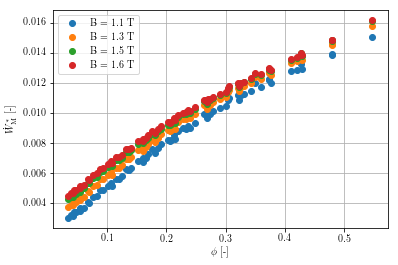

In [27]:
plt.plot(Pi_6[0:72],Pi_10[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_10[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_10[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_10[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{W}_\mathrm{M}^*$ [-]')
plt.legend()
plt.show()

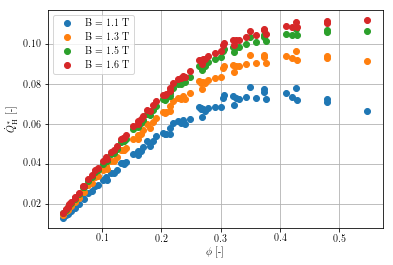

In [28]:
plt.plot(Pi_6[0:72],Pi_9[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_9[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_9[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_9[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{H}^*$ [-]')
plt.legend()
plt.show()

In [29]:
a = 0*72
b = 4*72

In [30]:
Coef_Wm = curve_fit(fitting_W,(Pi_6[a:b],Pi_4[a:b]),Pi_10[a:b],maxfev=10000)
Coef_Wm

(array([ 1.85012325e-03,  5.75123981e-01, -1.10499621e+01,  1.57263317e-07,
        -2.36039012e+00]),
 array([[ 3.87577581e-08,  4.48498378e-08,  9.27514527e-05,
          6.29378809e-13,  9.99196077e-07],
        [ 4.48498378e-08,  3.85086670e-05, -8.11031449e-05,
          1.81533317e-09,  3.15612136e-03],
        [ 9.27514527e-05, -8.11031449e-05,  2.22964344e-01,
         -6.33240688e-09, -1.11758768e-02],
        [ 6.29378809e-13,  1.81533317e-09, -6.33240688e-09,
          1.54043677e-13,  2.74427797e-07],
        [ 9.99196077e-07,  3.15612136e-03, -1.11758768e-02,
          2.74427797e-07,  4.90156729e-01]]))

NameError: name 'Coef' is not defined

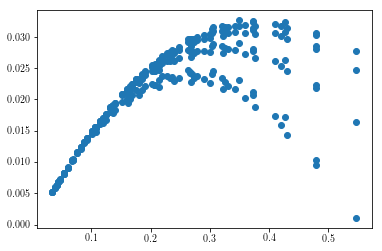

In [31]:
plt.plot(Pi_6[a:b],Pi_8[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o')

In [ ]:
plt.plot(Pi_6[a:b],Pi_9[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o')

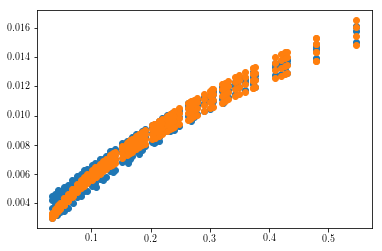

In [32]:
plt.plot(Pi_6[a:b],Pi_10[a:b],'o')
plt.plot(Pi_6[a:b],fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],0,Coef_Wm[0][4]),'o')

In [33]:
erro1 = abs((Pi_8 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]))/Pi_8*100)
erro2 = abs((Pi_9 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]))/Pi_9*100)
erro3 = abs((Pi_10 - fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]))/Pi_10*100)
j=0
h=0
k=0
for i in range(len(erro1)):
    if erro1[i] >= 10:
        j = j+1
    if erro2[i] >= 10:
        h = h+1
    if erro3[i] >= 10:
        k = k+1
j/len(erro1),h/len(erro2),k/len(erro3)

NameError: name 'Coef' is not defined

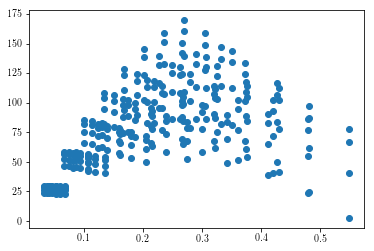

In [34]:
plt.plot(Pi_6,Q_c,'o')

In [35]:
plt.plot(Pi_6,erro1,'o')
plt.ylim([0,25])

NameError: name 'erro1' is not defined

In [36]:
plt.plot(Pi_6,erro1,'o',label = '$\dot{Q}_\mathrm{C}$')
plt.plot(Pi_6,erro2,'o',label = '$\dot{Q}_\mathrm{H}$')
plt.plot(Pi_6,erro3,'o',label = '$\dot{W}_\mathrm{M}$')
plt.ylim(0,30)
plt.xlabel('$\phi$ [-]')
plt.legend()
plt.ylabel('Error [$\%$]')
plt.grid()

NameError: name 'erro1' is not defined

In [37]:
plt.plot(Pi_6,erro3,'o')

NameError: name 'erro3' is not defined

In [38]:
plt.plot(Pi_8,fitting((Pi_6,Pi_7),Coef[0][0],Coef[0][1],Coef[0][2]),'o')
plt.plot(Pi_8,0.9*Pi_8)
plt.plot(Pi_8,1.1*Pi_8)
plt.grid()

NameError: name 'Coef' is not defined

In [ ]:
error_bar = np.arange(0,700)

In [124]:
K = (m_s*f*CdT_dmg)
plt.plot(Pi_8[0:72]*K[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o', label = 'B = 1.1 T')
plt.plot(Pi_8[72:2*72]*K[72:2*72],K[72:2*72]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'X', label = 'B = 1.3 T')
plt.plot(Pi_8[2*72:3*72]*K[2*72:3*72],K[2*72:3*72]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'s', label = 'B = 1.5 T')
plt.plot(Pi_8[3*72:4*72]*K[3*72:4*72],K[3*72:4*72]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.92*error_bar,'k--')
plt.plot(error_bar,1.08*error_bar,'k--')
plt.text(100,80,'- 8\%')
plt.text(80,110,'+ 8\%')


plt.xlabel('Numerical Cooling Capacity [W]')
plt.ylabel('Fitting Cooling Capacity [W]')

plt.grid()
plt.legend()
plt.xlim(0,180)
plt.ylim(0,180)

NameError: name 'm_s' is not defined

In [ ]:
plt.plot((Pi_9*K)[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o', label = 'B = 1.1 T')
plt.plot((Pi_9*K)[72:2*72],K[72:144]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'X', label = 'B = 1.3 T')
plt.plot((Pi_9*K)[2*72:3*72],K[144:216]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'s', label = 'B = 1.5 T')
plt.plot((Pi_9*K)[3*72:4*72],K[216:288]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(300,230,'- 10\%')
plt.text(250,350,'+ 10\%')


plt.xlabel('Numerical Rejected Heat [W]')
plt.ylabel('Fitting Rejected Heat [W]')

plt.grid()
plt.legend()
plt.xlim(20,550)
plt.ylim(20,550)

In [ ]:
plt.plot((Pi_10*K)[0:72],K[0:72]*fitting_W((Pi_6[0:72],Pi_4[0:72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'o', label = 'B = 1.1 T')
plt.plot((Pi_10*K)[72:2*72],K[72:144]*fitting_W((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'X', label = 'B = 1.3 T')
plt.plot((Pi_10*K)[2*72:3*72],K[144:216]*fitting_W((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'s', label = 'B = 1.5 T')
plt.plot((Pi_10*K)[3*72:4*72],K[216:288]*fitting_W((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(40,31.5,'- 8\%')
plt.text(31.5,45,'+ 8\%')


plt.xlabel('Numerical Magnetic Work[W]')
plt.ylabel('Fitting Magnetic Work [W]')

plt.grid()
plt.legend()
plt.xlim(5,70)
plt.ylim(5,70)